In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file = os.path.join(root, "config.cfg")

# tentar ler o config se existir
config = configparser.ConfigParser()
if os.path.exists(config_file):
    config.read(config_file)
    try:
        gdata_root = config["geodata"]["path"]
    except KeyError:
        print("⚠️ Seção 'geodata' ou chave 'path' não encontrada no config.cfg.")
        gdata_root = None
else:
    print("⚠️ Arquivo config.cfg não encontrado.")
    gdata_root = None

⚠️ Arquivo config.cfg não encontrado.


In [3]:
# get isakaya and ramen from OSM

#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:500];
area["ISO3166-1"="BR"][admin_level=2]->.searchArea;

(
  // 1. Busca por tags de culinária específica
  node["cuisine"~"japanese|ramen|izakaya|udon|soba|donburi"](area.searchArea);
  
  // 2. Busca em amenities relevantes com termos japoneses
  node["amenity"~"restaurant|bar|pub|fast_food"]["cuisine"~"japanese|ramen|noodle"](area.searchArea);
  node["amenity"~"restaurant|bar|pub"]["name"~"izakaya|ramen|lamen|japones|japa|nihon",i](area.searchArea);
  
  // 3. Termos relacionados a noodles e pubs japoneses
  node["name"~"noodle|menya|rámen|拉面",i](area.searchArea);
  node["name"~"japanese pub|jap pub|pub japones",i](area.searchArea);
  
  // 4. Redes conhecidas (Sukiya, Hokkai, Lamen House)
  node["name"~"sukiya|sukya|hokkai|lamen house|ramen house",i](area.searchArea);
  node["brand"~"sukiya|ippudo|ajisen",i](area.searchArea);
  
  // 5. Busca por descrição contendo termos japoneses
  node["description"~"japanese|ramen|izakaya",i](area.searchArea);
  
  // Limita ways/relations para tags explícitas
  way["cuisine"~"japanese|ramen|izakaya"](area.searchArea);
  rel["cuisine"~"japanese|ramen|izakaya"](area.searchArea);
);
(._;>;);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [4]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "shop":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "shop", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [5]:
gdf

,id,type,lat,lon,name,shop,amenity,geometry
0,324384214,node,-19.933872,-43.925668,Sushi Naka,,restaurant,POINT (-43.92567 -19.93387)
1,324390463,node,-19.935354,-43.935941,Chop Stick / Vinnil Cultura Bar,,restaurant,POINT (-43.93594 -19.93535)
2,465994688,node,-23.565700,-46.683440,El Kabong Grill,,restaurant,POINT (-46.68344 -23.5657)
3,561522274,node,-8.052623,-34.902331,Osaka,,restaurant,POINT (-34.90233 -8.05262)
4,582630942,node,-22.717848,-42.621772,,,,POINT (-42.62177 -22.71785)
...,...,...,...,...,...,...,...,...
2536,4441180,relation,-22.115878,-51.407154,Massashin,,fast_food,POINT (-51.40715 -22.11588)
2537,4479504,relation,-22.131864,-51.389857,Yakisushi,,fast_food,POINT (-51.38986 -22.13186)
2538,5610114,relation,-22.124938,-51.387816,Requinte Temakeria,,restaurant,POINT (-51.38782 -22.12494)
2539,5886222,relation,-22.121707,-51.418933,Zendai,,restaurant,POINT (-51.41893 -22.12171)


In [6]:

import re
from rapidfuzz import fuzz, process

# 1. Pré-processamento dos campos
for col in ['name', 'description', 'cuisine', 'brand', 'amenity', 'shop']:
    if col not in gdf.columns:
        gdf[col] = ''

# Normalização simplificada usando unicodedata
import unicodedata

def normalize_text(s):
    s = (s or '').lower().replace('&', ' e ')
    s = unicodedata.normalize('NFKD', s)
    return s.encode('ascii', errors='ignore').decode('utf-8')

# Aplicar limpeza básica
for field in ['name', 'description', 'cuisine', 'brand', 'amenity', 'shop']:
    gdf[field + '_clean'] = (
        gdf[field]
        .fillna('')
        .apply(normalize_text)
        .str.replace(r'[^\w\s]', '', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )

# 2. Listas de termos e sinônimos ampliadas
izakaya_terms = [
    'izakaya', '居酒屋', 'isakaya',
    'izakayá', 'yakitori', 'tori bar',
    'japa bar', 'jap bar', 'nihon bar',
    'bar japones', 'bar japonês', 'pub japones', 'japanese bar',
    'comida oriental', 'petiscos japoneses', 'petiscos orientais'
]
ramen_terms = [
    'ramen', 'lamen', 'rámen', '拉面', 'menya', 'ramenya',
    'ramen bar', 'ramen shop', 'noodle house', 'noodle',
    'macarrão japonês', 'macarrao japones', 'tonkotsu', 'shoyu ramen'
]
# Marcas conhecidas (com exemplos)
brands_izakaya = ['sukiya', 'ippudo', 'ganso', 'matsuya']
brands_ramen = ['ajisen', 'hokkai', 'ramen house', 'lamen house']

# 3. Função de categorização aprimorada
def categorize_poi(row):
    name = row['name_clean']
    desc = row['description_clean']
    cui = row['cuisine_clean']
    brd = row['brand_clean']
    amen = row['amenity_clean']
    shop = row['shop_clean']

    # a) Tags explícitas em cuisine ou brand
    if 'izakaya' in cui or any(b in brd for b in brands_izakaya):
        return 'Izakaya'
    if any(tok in cui for tok in ramen_terms) or any(b in brd for b in brands_ramen):
        return 'Ramen'

    # b) Fuzzy matching no nome
    iz = process.extractOne(name, izakaya_terms + brands_izakaya, scorer=fuzz.partial_ratio)
    if iz and iz[1] >= 75:
        return 'Izakaya'
    ram = process.extractOne(name, ramen_terms + brands_ramen, scorer=fuzz.partial_ratio)
    if ram and ram[1] >= 75:
        return 'Ramen'

    # c) Regex em nome e descrição
    if re.search(r'(' + '|'.join(re.escape(t) for t in izakaya_terms) + r')', name + ' ' + desc):
        return 'Izakaya'
    if re.search(r'(' + '|'.join(re.escape(t) for t in ramen_terms) + r')', name + ' ' + desc):
        return 'Ramen'

    # d) Contexto amenity/shop
    if amen in ['bar', 'pub'] and any(tok in name for tok in izakaya_terms):
        return 'Izakaya'
    if shop in ['ramen', 'noodle'] or (amen == 'fast_food' and any(tok in name for tok in ramen_terms)):
        return 'Ramen'

    # e) Termos genéricos de comida oriental
    if 'oriental' in name or 'oriental' in desc or 'oriental' in cui:
        # assume noodle-based
        return 'Ramen' if any(tok in name for tok in ramen_terms) else 'Izakaya'

    return 'Outros'

# 4. Aplica e avalia

gdf['category'] = gdf.apply(categorize_poi, axis=1)
print(gdf['category'].value_counts())


category
Outros     2283
Izakaya     187
Ramen        71
Name: count, dtype: int64


In [7]:
# top names
gdf["name_clean"].value_counts().to_frame().head(12)

,count
name_clean,
,1502
koni,11
bar do flamengo,9
gendai,6
koni store,4
sukiya,4
casa do sushi,3
kanpai,3
sushi garden,3


In [8]:
import geobr

In [9]:
states = geobr.read_state(year=2020)

(np.float64(-76.24759047175),
 np.float64(-26.590499411249997),
 np.float64(-35.70232894755),
 np.float64(7.22299203055))

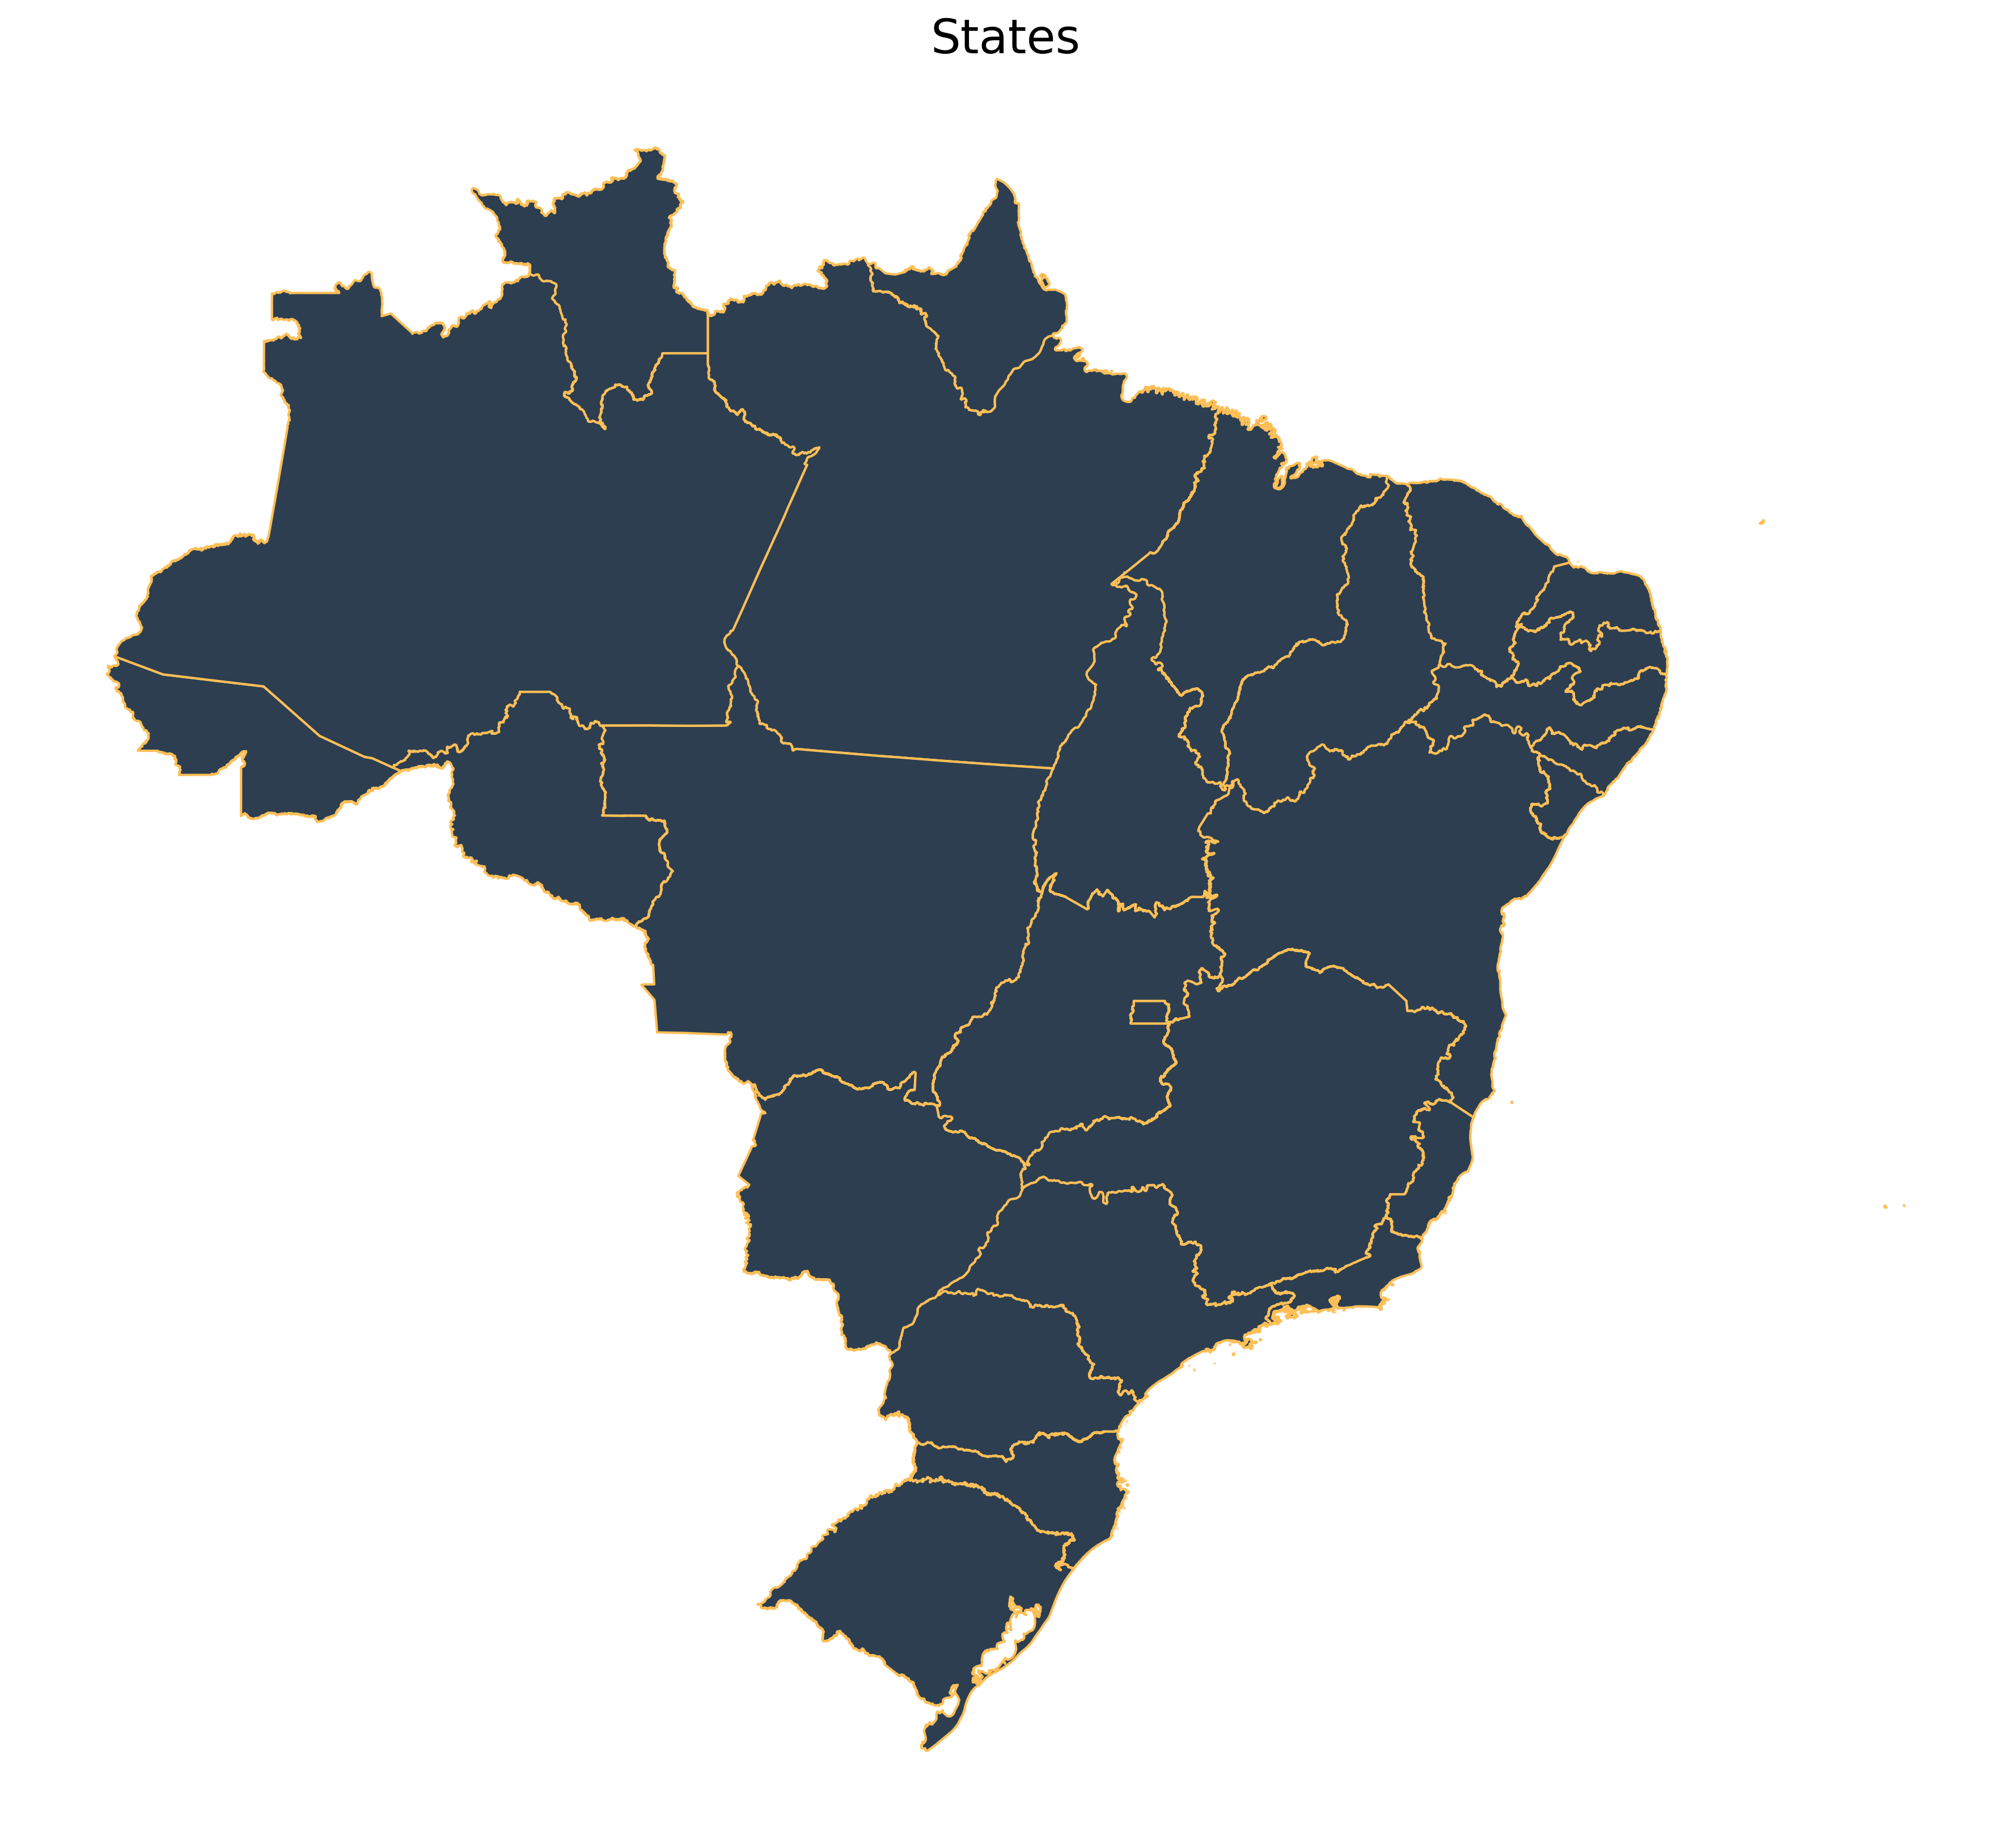

In [10]:
# Plot all Brazilian states
fig, ax = plt.subplots(figsize=(15, 15), dpi=300)

states.plot(facecolor="#2D3E50", edgecolor="#FEBF57", ax=ax)

ax.set_title("States", fontsize=20)
ax.axis("off")

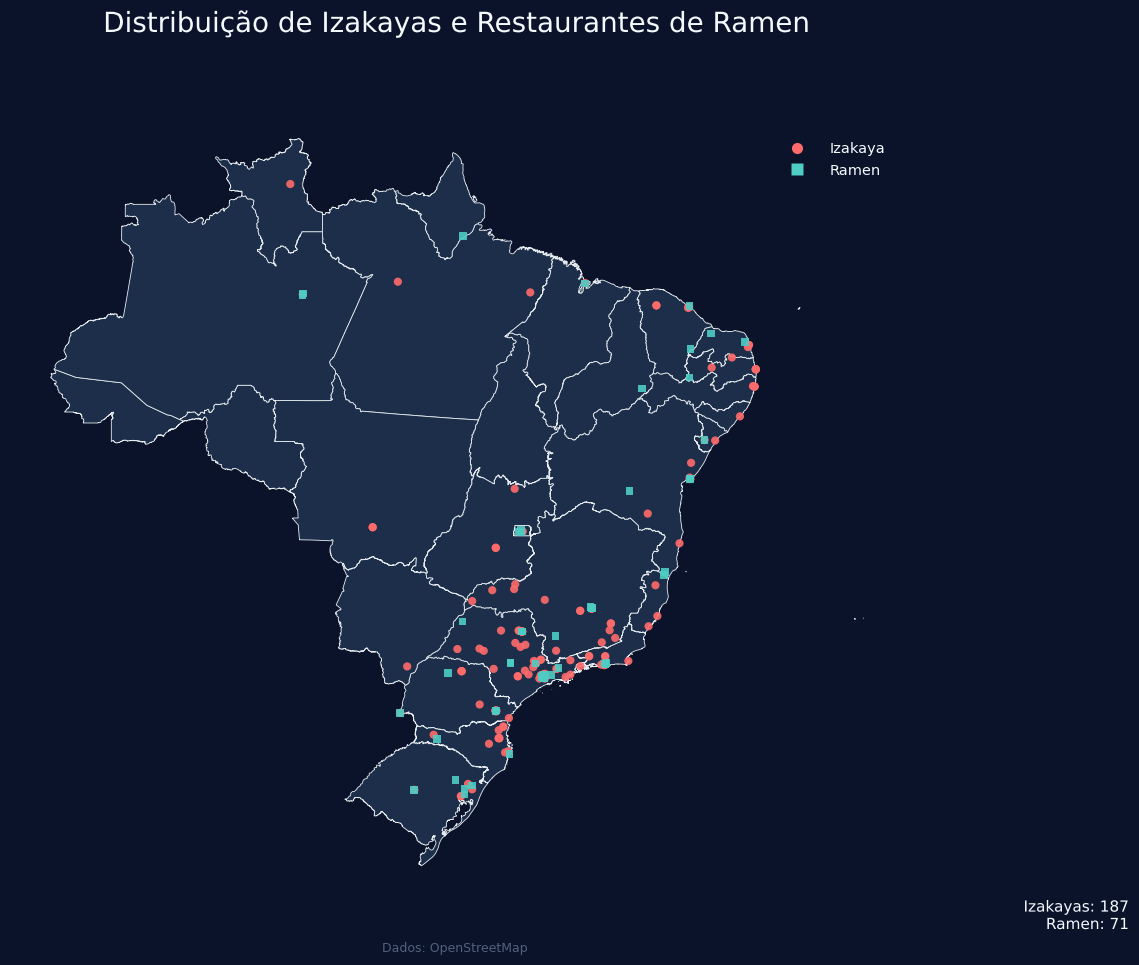

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from geobr import read_state

# ===== CORES AJUSTADAS E ELEGANTES =====
bg_color = "#0b132b"         # Fundo azul escuro profundo
font_color = "#f4faff"       # Branco azulado
state_fill_color = "#1c2e4a" # Azul petróleo para estados
border_color = "#e6ecf0"     # Branco acinzentado

colrs = {
    "Izakaya": "#ff6b6b",    # Coral elegante
    "Ramen": "#4ecdc4"       # Azul piscina vívido
}

# ===== DADOS DO MAPA (GEOBR) =====
states = read_state(year=2020, simplified=False)  # Fronteiras suaves e detalhadas

# ===== FIGURA E ESTILO =====
fig, ax = plt.subplots(figsize=(14, 10), facecolor=bg_color)
fig.set_facecolor(bg_color)

# ===== MAPA BASE DO BRASIL =====
states.plot(
    ax=ax,
    color=state_fill_color,
    edgecolor=border_color,
    linewidth=0.6,
    alpha=1
)

# ===== CONFIGURAÇÃO DOS MARCADORES =====
marker_config = {
    "Izakaya": {
        "marker": "o",
        "size": 35,
        "color": colrs["Izakaya"],
        "alpha": 0.9,
    },
    "Ramen": {
        "marker": "s",
        "size": 30,
        "color": colrs["Ramen"],
        "alpha": 0.9,
    }
}

# ===== PLOTAGEM DOS PONTOS =====
counts = {}  # Para armazenar contagens
for category, style in marker_config.items():
    gdf_filtered = gdf[gdf["category"] == category]
    counts[category] = len(gdf_filtered)

    gdf_filtered.plot(
        ax=ax,
        markersize=style["size"],
        marker=style["marker"],
        color=style["color"],
        alpha=style["alpha"],
        zorder=5,
        edgecolor="none",
        linewidth=0,
        path_effects=[
            path_effects.SimpleLineShadow(), 
            path_effects.Normal()
        ]
    )

# ===== EIXO INVISÍVEL =====
ax.axis("off")

# ===== LEGENDA REFINADA =====
legend_elements = [
    Line2D([0], [0], 
           marker='o', 
           color=bg_color, 
           label='Izakaya',
           markerfacecolor=colrs["Izakaya"], 
           markersize=8,
           markeredgecolor="none"),
    Line2D([0], [0], 
           marker='s', 
           color=bg_color, 
           label='Ramen',
           markerfacecolor=colrs["Ramen"], 
           markersize=8,
           markeredgecolor="none")
]

leg = ax.legend(
    handles=legend_elements,
    loc='upper right',
    frameon=True,
    framealpha=0.15,
    edgecolor='none',
    labelcolor=font_color,
    fontsize=10.5,
    title=" ",
    borderpad=0.8,
    handletextpad=1.2,
    borderaxespad=0.5
)
leg.get_frame().set_facecolor(bg_color)

# ===== TÍTULO COM SOMBRA =====
plt.figtext(
    0.5, 0.95, 
    "Distribuição de Izakayas e Restaurantes de Ramen", 
    fontsize=20, 
    ha="center", 
    color=font_color,
    fontweight="medium",
    fontfamily="DejaVu Sans",
    path_effects=[
        path_effects.Stroke(linewidth=1.5, foreground=bg_color),
        path_effects.Normal()
    ]
)

# ===== RODAPÉ DISCRETO =====
plt.figtext(
    0.5, 0.03, 
    "Dados: OpenStreetMap ", 
    fontsize=9, 
    ha="center", 
    color="#9baec8",
    alpha=0.5
)

# ===== CONTAGEM DE ESTABELECIMENTOS =====
contagem_texto = f"Izakayas: {counts.get('Izakaya', 0)}\nRamen: {counts.get('Ramen', 0)}"
plt.figtext(
    0.98, 0.05,
    contagem_texto,
    ha="right",
    va="bottom",
    fontsize=11,
    color=font_color,
    fontweight="regular",
    fontfamily="DejaVu Sans",
    path_effects=[
        path_effects.Stroke(linewidth=1.2, foreground=bg_color),
        path_effects.Normal()
    ]
)

# ===== SALVAR O MAPA COMO IMAGEM =====
plt.savefig("mapa_izakaya_ramen.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

# ===== EXIBIR O MAPA =====
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.88, bottom=0.08)
plt.show()
